In [1]:
from molbert.utils.featurizer.molbert_featurizer import MolBertFeaturizer
import pandas as pd
import numpy as np

from tqdm import tqdm

/home/mmasood1/.conda/envs/molbert/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

import logging
logger = logging.getLogger(__name__)
import gc


# In[2]:


import os, yaml
from argparse import Namespace

import pandas as pd
import numpy as np
from scipy.special import expit
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.metrics import average_precision_score, f1_score

from tqdm import tqdm

import torch
from torch import nn

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer
from torch.nn.modules.loss import CrossEntropyLoss
from pytorch_lightning import seed_everything



import wandb
os.environ["WANDB_SILENT"] = "true"
wandb.login(key = "27edf9c66b032c03f72d30e923276b93aa736429")


# In[3]:


from molbert.models.smiles import SmilesMolbertModel
from molbert.datasets.dataloading import MolbertDataLoader
from molbert.datasets.smiles import BertSmilesDataset
from molbert.utils.featurizer.molfeaturizer import SmilesIndexFeaturizer


# In[4]:


from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts, StepLR
from transformers import (
    AdamW,
    get_linear_schedule_with_warmup,
    get_cosine_schedule_with_warmup,
    get_constant_schedule_with_warmup,
    get_cosine_with_hard_restarts_schedule_with_warmup,
)


# In[5]:


# config_dict
model_weights_dir = '/projects/home/mmasood1/Model_weights/invitro/invitro_1million/MolBERT/Retrain_on_top_of_BERT/complete_1m_300k_ADME/without_physchem_head/'
pretrained_model_path = '/projects/home/mmasood1/TG GATE/MolBERT/molbert/molbert_100epochs/molbert_100epochs/checkpoints/last.ckpt'
data_dir = '/projects/home/mmasood1/arslan_data_repository/invitro/invitro_1m/25_04_2024/SMILES_len_th_128/'
pos_weights = "/projects/home/mmasood1/arslan_data_repository/invitro/invitro_1m/25_04_2024/pos_weights.csv"
metadata_dir = "/projects/home/mmasood1/trained_model_predictions/SIDER_PreClinical/BERT_finetune/MF/"
model_dir = os.path.dirname(os.path.dirname(pretrained_model_path))
hparams_path = os.path.join(model_dir, 'hparams.yaml')
# load config
with open(hparams_path) as yaml_file:
    config_dict = yaml.load(yaml_file, Loader=yaml.FullLoader)

config_dict['project_name'] = "BERT_invitro_ADME_pretraining"
config_dict['model_name'] = "SMILES_len_th_128_Permute_False_PhySchem_False"

config_dict['model_weights_dir'] = model_weights_dir
config_dict['pretrained_model_path'] = pretrained_model_path
config_dict["metadata_dir"] = metadata_dir
config_dict['pos_weights'] = pos_weights
config_dict['data_dir'] = data_dir
config_dict['train_file'] = data_dir + "train_set_invitro_1m_300k_ADME_filtered.pkl"
config_dict['valid_file'] = data_dir + "test_set_invitro_1m_300k_ADME_filtered.pkl"
config_dict['test_file'] = data_dir + "test_set_invitro_1m_300k_ADME_filtered.pkl"

config_dict['mode'] = 'classification'
config_dict['alpha'] = 0.0
config_dict['beta'] = 0.0
config_dict['gamma'] = 0.0

config_dict['max_epochs'] = 50
config_dict['unfreeze_epoch'] = 210
config_dict["l2_lambda"] = 0.0
config_dict['embedding_size'] = 50
config_dict["num_physchem_properties"] = 200
config_dict["num_invivo_tasks"] = 0

config_dict['optim'] = 'AdamW'#SGD
config_dict['loss_type'] = 'BCE'# Focal_loss

config_dict['lr'] = 1e-05
config_dict["BERT_lr"] = 3e-5
config_dict["batch_size"] = 264
config_dict["seed"] = 42



config_dict['missing'] = 'nan'
config_dict['compute_metric_after_n_epochs'] = 5
config_dict['return_trainer'] = True
config_dict['EarlyStopping'] = False

config_dict["accelerator"] = "gpu"
config_dict["device"] = torch.device("cuda")


data = pd.read_pickle(config_dict['train_file'])
data.drop(['SMILES'], axis = 1, inplace = True)
target_names = data.columns.tolist()

config_dict["output_size"] = len(target_names)
config_dict["num_invitro_tasks"] = len(target_names)
config_dict["num_of_tasks"] = len(target_names)

config_dict["label_column"] = target_names
config_dict["selected_tasks"] = target_names
config_dict['num_mols'] = data.shape[0]
config_dict['max_seq_length'] = 128
config_dict['bert_output_dim'] = 768
config_dict['invitro_head_hidden_layer'] = 2048

config_dict["permute"] = False

config_dict['pretrained_model'] = True
config_dict['freeze_level'] = False
config_dict["gpu"] = -1
config_dict["precision"] = 32
config_dict["distributed_backend"] = "dp"
config_dict["pretrained_crash_model"] = None #"/projects/home/mmasood1/Model_weights/invitro/invitro_1million/MolBERT/Retrain_on_top_of_BERT/complete_1m_300k/invitro_with_PhysChem/epoch=2-val_f1_score=0.00.ckpt"

In [7]:
import logging
from typing import Tuple, Sequence, Any, Dict, Union, Optional

import numpy as np
import torch

from molbert.utils.featurizer.molfeaturizer import SmilesIndexFeaturizer

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
logger = logging.getLogger(__name__)

class MolBertFeaturizer:
    """
    This featurizer takes a molbert model and transforms the input data and
    returns the representation in the last layer (pooled output and sequence_output).
    """

    def __init__(
        self,
        model,
        featurizer,
        device: str = None,
        embedding_type: str = 'pooled',
        max_seq_len: Optional[int] = None,
        permute: bool = False,
    ) -> None:
        """
        Args:
            checkpoint_path: path or S3 location of trained model checkpoint
            device: device for torch
            embedding_type: method to reduce MolBERT encoding to an output set of features. Default: 'pooled'
                Other options are embeddings summed or concat across layers, and then averaged
                Raw sequence and pooled output is also available (set to 'dict')
                average-sum-[2|4], average-cat-[2,4], average-[1|2|3|4], average-1-cat-pooled, pooled, dict
            max_seq_len: used by the tokenizer, SMILES longer than this will fail to featurize
                MolBERT was trained with SuperPositionalEncodings (TransformerXL) to decoupled from the training setup
                By default the training config is used (128). If you have long SMILES to featurize, increase this value
        """
        super().__init__()
        self.device = device or 'cuda' if torch.cuda.is_available() else 'cpu'
        self.embedding_type = embedding_type
        self.max_seq_len = max_seq_len
        self.permute = permute

        # load smiles index featurizer
        self.featurizer = featurizer

        # load model
        self.model = model

    def __getstate__(self):
        self.__dict__.update({'model': self.model.to('cpu')})
        self.__dict__.update({'device': 'cpu'})
        return self.__dict__

    @property

    def transform_single(self, smiles: str) -> Tuple[np.ndarray, bool]:
        features, valid = self.transform([smiles])
        return features, valid[0]

    def transform(self, molecules: Sequence[Any]) -> Tuple[Union[Dict, np.ndarray], np.ndarray]:
        input_ids, valid = self.featurizer.transform(molecules)

        input_ids = self.trim_batch(input_ids, valid)

        token_type_ids = np.zeros_like(input_ids, dtype=np.int64)
        attention_mask = np.zeros_like(input_ids, dtype=np.int64)

        attention_mask[input_ids != 0] = 1

        input_ids = torch.tensor(input_ids, dtype=torch.long, device=self.device)
        token_type_ids = torch.tensor(token_type_ids, dtype=torch.long, device=self.device)
        attention_mask = torch.tensor(attention_mask, dtype=torch.long, device=self.device)

        with torch.no_grad():
            outputs = self.model.model.bert(
                input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask
            )

        sequence_output, pooled_output = outputs

        # set invalid outputs to 0s
        valid_tensor = torch.tensor(
            valid, dtype=sequence_output.dtype, device=sequence_output.device, requires_grad=False
        )

        pooled_output = pooled_output * valid_tensor[:, None]
        sequence_out = sequence_output * valid_tensor[:, None, None]

        sequence_out = sequence_out.detach().cpu().numpy()
        pooled_output = pooled_output.detach().cpu().numpy()
        out = pooled_output

        return out, valid

    @staticmethod
    def trim_batch(input_ids, valid):

        # trim input horizontally if there is at least 1 valid data point
        if any(valid):
            _, cols = np.where(input_ids[valid] != 0)
        # else trim input down to 1 column (avoids empty batch error)
        else:
            cols = np.array([0])

        max_idx: int = int(cols.max().item() + 1)

        input_ids = input_ids[:, :max_idx]

        return input_ids

# Tox21 BERT Representations

In [4]:
target_file = "/projects/home/mmasood1/arslan_data_repository/Tox21/complete_Tox21_with_Normalized_SMILES.csv"
data = pd.read_csv(target_file)
SMILES = data.SMILES.tolist()
len(SMILES)

7676

In [5]:
model = SmilesMolbertModel(config_dict)
checkpoint = torch.load(config_dict["pretrained_model_path"], map_location=lambda storage, loc: storage)
model.load_state_dict(checkpoint['state_dict'], strict = False)
model.eval()
model.freeze()
model = model.to("cpu")

featurizer = SmilesIndexFeaturizer.bert_smiles_index_featurizer(126, permute = False)
f = MolBertFeaturizer(model = model,
                        featurizer= featurizer,
                        device = "cpu")

features_all, masks_all = [],[]
for s in tqdm(SMILES):
    features, masks = f.transform([s])
    features_all.append(features.squeeze())
    masks_all.append(masks)

42


100%|██████████| 7676/7676 [14:13<00:00,  9.00it/s]


In [9]:
filtered = [mask[0] for mask in masks_all]

features = pd.DataFrame(features_all)
features = features[filtered]

selected_SMILES = data[filtered].SMILES.values
features.insert(0,"SMILES", selected_SMILES)

In [10]:
features

,SMILES,0,1,2,3,4,5,6,7,8,...,758,759,760,761,762,763,764,765,766,767
0,CCOC1=CC=C2N=C(S(N)(=O)=O)SC2=C1,-0.999468,-0.624080,0.956425,0.999400,-0.959755,0.858297,0.956004,-0.958891,0.893992,...,0.157030,-1.000000,0.615425,0.996496,-0.307102,-0.988310,0.658686,-0.999895,-0.606714,0.279612
1,CCN1C(=O)NC(C2=CC=CC=C2)C1=O,-0.998800,-0.394690,0.417706,0.785511,-0.999984,-0.297775,0.952522,-0.752922,-0.637202,...,-0.845625,-1.000000,-0.522677,0.607426,-0.572800,-0.994835,-0.876173,-0.997824,0.968187,-0.890742
2,CCC1(O)CCC2C3CCC4=CCCCC4C3CCC21C,0.992950,-0.808335,0.008946,-0.111789,-0.874823,-0.968280,0.866496,-0.703462,0.960225,...,-0.099530,-1.000000,-0.934382,0.999943,-0.511458,0.999970,-0.213355,-0.997537,-0.788796,0.015034
3,CCCN(CC)C(CC)C(=O)NC1=C(C)C=CC=C1C,-0.779247,0.332787,0.861110,0.824433,-0.866848,-0.554419,0.893834,-0.906609,-0.995527,...,-0.448646,-1.000000,0.958813,-0.792171,0.791655,0.944895,-0.364108,-0.999962,0.252769,-0.955980
4,CC(O)(P(=O)(O)O)P(=O)(O)O,-0.889839,0.939535,-0.891704,0.786544,-0.917653,-0.923348,0.965484,-0.791715,-0.998794,...,-0.835915,-1.000000,-0.648879,0.997913,0.370811,-0.999423,-0.973687,-0.955154,-0.972863,0.978498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7671,CCCN1C(=O)NC(=O)C2=C1N=CN2,-0.999448,-0.129157,0.531828,-0.154613,-0.993606,0.961474,0.945498,-0.898837,0.619754,...,0.324913,-1.000000,-0.452538,0.999498,0.500917,0.113066,-0.019181,-0.999712,0.090855,-0.113753
7672,CCCNCC(O)COC1=CC=CC=C1C(=O)CCC1=CC=CC=C1,-0.946272,0.270523,0.044216,-0.450673,0.570527,-0.185225,0.803215,-0.898003,0.611435,...,0.705826,-0.999999,0.871525,0.999995,0.632817,0.763725,-0.888236,-0.999249,-0.570374,-0.425040
7673,CCOC1=NC2=CC=CC(C(=O)O)=C2N1CC1=CC=C(C2=CC=CC=...,-0.644287,0.954767,0.349403,-0.065765,0.183635,0.999478,0.218042,-0.589496,-0.778568,...,-0.197343,1.000000,-0.034068,0.999696,-0.009676,-0.292789,-0.999587,-0.999159,-0.898854,0.912531
7674,CC(=O)C1CCC2C3CCC4=CC(=O)CCC4(C)C3CCC12C,0.979926,-0.948712,0.174612,0.033564,-0.876596,-0.070293,0.955273,-0.846144,0.159967,...,-0.388863,-1.000000,-0.207475,0.995059,-0.145911,0.999464,-0.816481,-0.999580,0.353261,-0.317089


In [8]:
features.to_csv("/projects/home/mmasood1/arslan_data_repository/Tox21/Tox21_BERT_features.csv", index = False)

# DILI dataset

In [25]:
target_file = "/projects/home/mmasood1/arslan_data_repository/DILI/test_normalized_seed_1.csv"
data = pd.read_csv(target_file)
SMILES = data.Normalized_SMILES.tolist()
len(SMILES)

96

In [26]:
model = SmilesMolbertModel(config_dict)
checkpoint = torch.load(config_dict["pretrained_model_path"], map_location=lambda storage, loc: storage)
model.load_state_dict(checkpoint['state_dict'], strict = False)
model.eval()
model.freeze()
model = model.to("cpu")

featurizer = SmilesIndexFeaturizer.bert_smiles_index_featurizer(126, permute = False)
f = MolBertFeaturizer(model = model,
                        featurizer= featurizer,
                        device = "cpu")

features_all, masks_all = [],[]
for s in tqdm(SMILES):
    features, masks = f.transform([s])
    features_all.append(features.squeeze())
    masks_all.append(masks)

42


100%|██████████| 96/96 [00:04<00:00, 19.64it/s]


In [27]:
filtered = [mask[0] for mask in masks_all]

features = pd.DataFrame(features_all)
features = features[filtered]

selected_SMILES = data[filtered].Normalized_SMILES.values
features.insert(0,"SMILES", selected_SMILES)

In [28]:
filtered_data = data[data.Normalized_SMILES.isin(selected_SMILES)].reset_index(drop = True)

In [29]:
filtered_data

,Drug_ID,SMILES,Y,Normalized_SMILES
0,443884.0,CC(CO)NC(=O)C1C=C2c3cccc4[nH]cc(c34)CC2N(C)C1,0.0,CC(CO)NC(=O)C1C=C2C3=CC=CC4=C3C(=CN4)CC2N(C)C1
1,9681.0,CCC(CO)NC(=O)C1C=C2c3cccc4c3c(cn4C)CC2N(C)C1,0.0,CCC(CO)NC(=O)C1C=C2C3=CC=CC4=C3C(=CN4C)CC2N(C)C1
2,8226.0,CCC(CO)NC(=O)C1C=C2c3cccc4[nH]cc(c34)CC2N(C)C1,0.0,CCC(CO)NC(=O)C1C=C2C3=CC=CC4=C3C(=CN4)CC2N(C)C1
3,4474.0,COC(=O)C1=C(C)NC(C)=C(C(=O)OCCN(C)Cc2ccccc2)C1...,1.0,COC(=O)C1=C(C)NC(C)=C(C(=O)OCCN(C)CC2=CC=CC=C2...
4,4976.0,CNCCCC1c2ccccc2C=Cc2ccccc21,0.0,CNCCCC1C2=CC=CC=C2C=CC2=CC=CC=C21
...,...,...,...,...
89,3724.0,CC(=O)N(CC(O)CN(C(C)=O)c1c(I)c(C(=O)NCC(O)CO)c...,0.0,CC(=O)N(CC(O)CN(C(C)=O)C1=C(I)C(C(=O)NCC(O)CO)...
90,4917.0,CN1CCN(CCCN2c3ccccc3Sc3ccc(Cl)cc32)CC1,1.0,CN1CCN(CCCN2C3=CC=CC=C3SC3=CC=C(Cl)C=C32)CC1
91,5291.0,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc...,1.0,CC1=CC=C(NC(=O)C2=CC=C(CN3CCN(C)CC3)C=C2)C=C1N...
92,5717.0,COc1cc(C(=O)NS(=O)(=O)c2ccccc2C)ccc1Cc1cn(C)c2...,1.0,COC1=CC(C(=O)NS(=O)(=O)C2=CC=CC=C2C)=CC=C1CC1=...


In [30]:
filtered_data.to_csv("/projects/home/mmasood1/arslan_data_repository/DILI/test_normalized_filtered_seed_1.csv", index = False)

# Preclinical clinical Representaions

In [10]:
target_dir = "/projects/home/mmasood1/arslan_data_repository/Mix_clinical_pre_clinical/02_05_2024/Representations_BERT_invitro_pretrained/Retrain_top_of_BERT_with_Physchem/"
data = pd.read_csv(target_dir + "clinical_pre_clinical_with_blood_marker_filtered.csv")
SMILES = data.SMILES.tolist()
len(SMILES)

1554

In [11]:
model = SmilesMolbertModel(config_dict)
checkpoint = torch.load(config_dict["pretrained_model_path"], map_location=lambda storage, loc: storage)
model.load_state_dict(checkpoint['state_dict'], strict = False)
model.eval()
model.freeze()
model = model.to("cpu")

featurizer = SmilesIndexFeaturizer.bert_smiles_index_featurizer(128, permute = False)
f = MolBertFeaturizer(model = model,
                        featurizer= featurizer,
                        device = "cpu")

features_all, masks_all = [],[]
for s in tqdm(SMILES):
    features, masks = f.transform([s])
    features_all.append(features.squeeze())
    masks_all.append(masks)

42


100%|██████████| 1554/1554 [04:00<00:00,  6.46it/s]


In [12]:
filtered = [mask[0] for mask in masks_all]

features = pd.DataFrame(features_all)
features = features[filtered]

selected_SMILES = data[filtered].SMILES.values
features.insert(0,"SMILES", selected_SMILES)

In [14]:
BERT_dir = "/projects/home/mmasood1/arslan_data_repository/Mix_clinical_pre_clinical/02_05_2024/Representations_BERT_invitro_pretrained/Original_BERT/"
features.to_csv(BERT_dir + f"preclinical_clinical_features_extracted_from_original_BERT.csv", index= False)

In [ ]:
#selected_data = data[masks].reset_index(drop = True)
#selected_data.to_csv("/projects/home/mmasood1/arslan_data_repository/Mix_clinical_pre_clinical/18_01_2023/Filtered_data_for_BERT/clinical_pre_clinical_with_blood_marker.csv", index= False)

In [ ]:

represntations = features[masks]
represntations = pd.DataFrame(represntations)
represntations.insert(0, "SMILES", data.SMILES.values)
#represntations.to_csv("/projects/home/mmasood1/arslan_data_repository/Mix_clinical_pre_clinical/18_01_2023/Filtered_data_for_BERT/BERT_rerpesentations_pretrained_masking.csv", index= False)
represntations.to_csv("/projects/home/mmasood1/arslan_data_repository/Mix_clinical_pre_clinical/18_01_2023/Filtered_data_for_BERT/BERT_rerpesentations_pretrained_homolumo_updated.csv", index= False)

In [ ]:
r_old = represntations.iloc[1,2:-1]
r_old

In [ ]:
r = pd.read_csv("/projects/home/mmasood1/arslan_data_repository/Mix_clinical_pre_clinical/18_01_2023/Filtered_data_for_BERT/BERT_rerpesentations_pretrained_homolumo.csv")

# invitro representations

In [ ]:
from tqdm import tqdm

In [ ]:
data_dir = "/projects/home/mmasood1/arslan_data_repository/Mix_clinical_pre_clinical/Data_for_BERT_pretraining/"
data = pd.read_csv(data_dir + "in_vitro_processed.csv")
SMILES = data.Normalized_SMILES.tolist()
len(SMILES)

In [ ]:
path_to_checkpoint = '/projects/home/mmasood1/TG GATE/MolBERT/molbert/molbert_100epochs/molbert_100epochs/checkpoints/last.ckpt'
#path_to_checkpoint = '/projects/home/mmasood1/TG GATE/MolBERT/molbert/molbert_100epochs/molbert_100epochs/checkpoints/homolumo.ckpt'

features_all = []
masks_all = []
f = MolBertFeaturizer(path_to_checkpoint)
features_all, masks_all = [],[]
for i in tqdm(range(len(SMILES))):
    features, masks = f.transform(SMILES[i])
    features_all.append(features)
    masks_all.append(masks)

In [ ]:
filtered_data = data[masks].reset_index(drop = True)
SMILES = filtered_data["Normalized_SMILES"].tolist()

represntations = features[masks]
represntations = pd.DataFrame(represntations)
represntations.insert(0, "Normalized_SMILES", SMILES)
represntations.to_csv(data_dir + f"BERT_masked_pretrained_invitro_canonical_SMILES.csv", index= False)
filtered_data.to_csv(data_dir + "invitro_filtered.csv", index= False)

In [ ]:
# Get representations of preclinical SMIES
BERT_dir = "/projects/home/mmasood1/arslan_data_repository/Mix_clinical_pre_clinical/18_01_2023/Filtered_data_for_BERT/"
preclinical_data = pd.read_csv(BERT_dir + "preclinical_with_multiple_type_SMILES.csv")

In [ ]:
path_to_checkpoint = '/projects/home/mmasood1/TG GATE/MolBERT/molbert/molbert_100epochs/molbert_100epochs/checkpoints/last.ckpt'
#path_to_checkpoint = '/projects/home/mmasood1/TG GATE/MolBERT/molbert/molbert_100epochs/molbert_100epochs/checkpoints/homolumo.ckpt'
f = MolBertFeaturizer(path_to_checkpoint)

SMILES_type = ["StandardizeSmiles","FragmentParent","SaltRemover","isomericSmiles","kekuleSmiles","canonical", "NoPreprocessing"]
for s_type in SMILES_type:
    if s_type == "NoPreprocessing":
        SMILES = preclinical_data[f"SMILES"].tolist()
    else:
        SMILES = preclinical_data[f"{s_type}_SMILES"].tolist()
    
    features, masks = f.transform(SMILES)
    
    represntations = features[masks]
    represntations = pd.DataFrame(represntations)
    represntations.insert(0, f"{s_type}_SMILES", np.array(SMILES)[masks])
    represntations.to_csv(BERT_dir + f"BERT_masked_pretrained_preclinical_{s_type}_SMILES.csv", index= False)
    print(s_type, represntations.shape)


# Updated invitro set, check validity

In [1]:
from molbert.utils.featurizer.molfeaturizer import SmilesIndexFeaturizer
import pandas as pd
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
def remove_long_smiles(args):
    smile, seed = args
    valid = False

    #permuted_seq = featurizer.permute_smiles(smile, seed=seed)
    orginal_smiles_len = len(smile)
    permuted_smiles_len = len(smile)
    #if (len(permuted_seq) <= max_len) & (featurizer.is_legal(smile)):
    if (featurizer.is_short(smile)) & (featurizer.is_legal(smile)):

        valid = True
    return valid, orginal_smiles_len,permuted_smiles_len

def convert_SMILES_to_features_parallel(smiles_list, seed):
    with Pool() as pool:
        
        validity, or_smiles_length, pr_smiles_length = [],[],[]
        total = len(smiles_list)
        with tqdm(total=total, ncols=80, desc="Processing") as pbar:
            for valid in pool.imap(remove_long_smiles, [(smile, seed) for smile in smiles_list]):
                validity.append(valid[0])
                or_smiles_length.append(valid[1])
                pr_smiles_length.append(valid[2])

                pbar.update(1)
    return validity, or_smiles_length, pr_smiles_length

In [3]:
data_dir = "/projects/home/mmasood1/arslan_data_repository/invitro/invitro_1m/25_04_2024/"
targets = pd.read_pickle(data_dir + 'invitro_1m_300k_ADME_labels.pkl')
SMILES_information = pd.read_pickle(data_dir + 'invitro_1m_300k_ADME_SMILES.pkl')
smiles_list = SMILES_information.Normalized_SMILES.tolist()

In [4]:
max_len = 126
featurizer = SmilesIndexFeaturizer.bert_smiles_index_featurizer(max_len, permute=False)

seeds = [0]

# Get validity lists for each seed
validity_lists = []
for seed in seeds:
    output = convert_SMILES_to_features_parallel(smiles_list, seed)
    validity_lists.append(output[0])

# Multiply the validity lists element-wise
result = np.prod(validity_lists, axis=0)

Processing: 100%|██████████████████| 1267966/1267966 [00:25<00:00, 49063.27it/s]


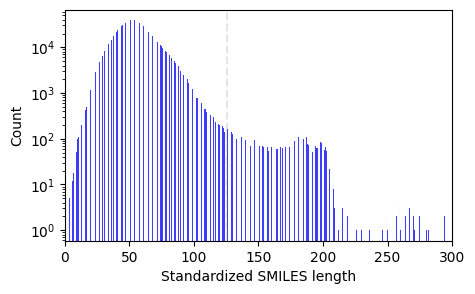

In [5]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (5,3),
                    gridspec_kw = {'wspace':0.5, 'hspace':0.5},
                    #sharey = 'col',
                    #sharex = True
                    )
sns.histplot(output[1], color= "Blue", label = "Standardized SMILEs", )
#ax = sns.histplot(output[2], color = "Red", label = "Permuted SMILEs")
ax.set_xlim(0, 300)
ax.set_yscale("log")
ax.set_xlabel("Standardized SMILES length")
ax.axvline(x=126, ls = '--', color = "Gray", alpha = 0.2)
#fig.savefig("/projects/home/mmasood1/TG GATE/Fig/invitro/invitro_smiles_length_distribution.png",
#               dpi = 300)

In [6]:
valid = result.astype(bool).tolist()

In [7]:
filtered_smiles = len(smiles_list) - np.array(valid).sum()
print(f"We filtered {filtered_smiles} SMILES")

filtered_SMILES = SMILES_information[valid].reset_index(drop = True)
filtered_targets = targets[valid].reset_index(drop = True)

data_dir = "/projects/home/mmasood1/arslan_data_repository/invitro/invitro_1m/25_04_2024/SMILES_len_th_128/"
filtered_targets.to_pickle(data_dir + 'invitro_1m_300k_ADME_labels_filtered.pkl')
filtered_SMILES.to_pickle(data_dir + 'invitro_1m_300k_ADME_SMILES_filtered.pkl')

We filtered 6520 SMILES


In [7]:
pos_th, neg_th = 100, 100
selected_tasks  = (filtered_targets == 1).sum(axis = 0) >= pos_th
selected_tasks = pd.DataFrame(selected_tasks)
selected_tasks.columns = ['selected_col']
selected_tasks = selected_tasks[selected_tasks.selected_col == True]
selected_tasks = selected_tasks.index.tolist()
selected_data = targets.filter(selected_tasks)

selected_tasks  = (filtered_targets == 0).sum(axis = 0) >= pos_th
selected_tasks = pd.DataFrame(selected_tasks)
selected_tasks.columns = ['selected_col']
selected_tasks = selected_tasks[selected_tasks.selected_col == True]
selected_tasks = selected_tasks.index.tolist()
selected_data = selected_data.filter(selected_tasks)

#active_labels = active_labels.groupby("task_name")["label"].size().reset_index().sort_values(by = "label", ascending = False)
#selected_tasks = active_labels[active_labels.label >= pos_th].task_name.values
#selected_tasks
#selected_data = selected_data[selected_data.task_name.isin(selected_tasks)]
#discarded_col = pd.DataFrame(discarded_col)
#discarded_col.columns = ['Discard']
#discarded_col[discarded_col.Discard == True]

In [10]:
columns_to_be_removed = list(set(targets.columns.tolist()) - set(selected_data.columns.tolist()))
columns_to_be_removed = pd.DataFrame(columns_to_be_removed)
columns_to_be_removed.columns = ["Columns_to_be_removed"]
columns_to_be_removed.to_csv("/projects/home/mmasood1/arslan_data_repository/invitro/invitro_1m/25_04_2024/th_100_columns_tobe_removed.txt", sep = '\t', index = False)

In [14]:
pd.read_csv("/projects/home/mmasood1/arslan_data_repository/invitro/invitro_1m/25_04_2024/th_128_columns_tobe_removed.txt", sep = '\t')

,Columns_to_be_removed
0,PIRLAB_1.131_pIC50_5.0
1,ABCD_11252_pAC50_6.0
2,5HT1B-ANT_level_6.0_prEff50
3,PIRLAB_402.16_pIC50_6.0
4,PIRLAB_402.374_pIC50_6.0
5,ABCD_1258_pEC50_5.0
6,ABCD_10440_pAC50_6.0
7,Glu72h_level_6.0
8,PIRLAB_402.203_pIC50_6.0
9,bp2543_level_5.0


In [9]:
discarded_data = targets.drop(targets[valid].index)
discarded_data

,ABCD_10003_pAC50_5.0,ABCD_10003_pAC50_6.0,ABCD_1005_pIC50_5.0,ABCD_10083_pAC50_5.0,ABCD_10188_pAC50_5.0,ABCD_10188_pAC50_6.0,ABCD_10222_pAC50_5.0,ABCD_10222_pAC50_6.0,ABCD_10225_pAC50_5.0,ABCD_10254_pAC50_5.0,...,p450inh_2c9_level_5.0,p450inh_2d6_level_5.0,p450inh_1a2_level_5.0,p450inh_2c19_level_5.0,cytoHepG248BE_level_4.5,cytoA54924BE_level_4.5,cytoA54948BE_level_4.5,cytoA54972BE_level_4.5,cytoHepG224BE_level_4.5,cytoHepG272BE_level_4.5
2502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15836,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1234958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
1234959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
1234964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1234969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [10]:
pos = pd.DataFrame((discarded_data == 1).sum(axis = 0))
neg = pd.DataFrame((discarded_data == 0).sum(axis = 0))
data = pd.concat([pos, neg], axis = 1)
data.columns = ["pos", "neg"]
data["total"] = data["pos"] + data["neg"]
data = data[data.sum(axis = 1) !=0]
data.index = data.index.set_names(['Target'])
data = data.reset_index()
data.sort_values(by = "total", ascending= False, inplace = True)
data.to_csv("/projects/home/mmasood1/arslan_data_repository/invitro/invitro_1m/25_04_2024/discarded_cmp_th_128.txt", sep = '\t', index = False)

In [15]:
data = pd.read_csv("/projects/home/mmasood1/arslan_data_repository/invitro/invitro_1m/25_04_2024/discarded_cmp_th_100.txt", sep = '\t')
data.sum()

Target    p450inh_3a4_level_5.0p450inh_2d6_level_5.0p450...
pos                                                   29185
neg                                                   84017
total                                                113202
dtype: object

# Check preclinical-clinical validity

In [3]:
data_dir = "/projects/home/mmasood1/arslan_data_repository/Mix_clinical_pre_clinical/02_05_2024/"
targets = pd.read_csv(data_dir + 'clinical_pre_clinical_with_blood_marker.csv')
smiles_list = targets.SMILES.tolist()

In [10]:
max_len = 128
featurizer = SmilesIndexFeaturizer.bert_smiles_index_featurizer(max_len, permute=False)

seeds = [0]

# Get validity lists for each seed
validity_lists = []
for seed in seeds:
    output = convert_SMILES_to_features_parallel(smiles_list, seed)
    validity_lists.append(output[0])

# Multiply the validity lists element-wise
result = np.prod(validity_lists, axis=0)

Processing: 100%|████████████████████████| 1653/1653 [00:00<00:00, 11093.27it/s]


In [18]:
valid = result.astype(bool).tolist()
filtered_smiles = len(smiles_list) - np.array(valid).sum()
print(f"We filtered {filtered_smiles} SMILES")

filtered_targets = targets[valid].reset_index(drop = True)
filtered_targets
data_dir = "/projects/home/mmasood1/arslan_data_repository/Mix_clinical_pre_clinical/02_05_2024/"
filtered_targets.to_csv(data_dir + 'clinical_pre_clinical_with_blood_marker_filtered.csv', index = False)


We filtered 99 SMILES


In [8]:
max_len = 128
featurizer = SmilesIndexFeaturizer.bert_smiles_index_featurizer(max_len, permute=True)
print(len(smiles_list[-1]))
print(len(featurizer.permute_smiles(smiles_list[-1])))
print(featurizer.permute_smiles(smiles_list[-1]))

52
54
C(CNC(=O)OCCOC)CCC(C(=O)NCCCCCCCOP(O)(C)=O)NC(OCCOC)=O


In [9]:
smiles_list[-1]

'COCCOC(=O)NCCCCC(NC(=O)OCCOC)C(=O)NCCCCCCCOP(C)(=O)O'

In [ ]:
from molbert.utils.featurizer.molfeaturizer import SmilesIndexFeaturizer
from molbert.utils.featurizer.molbert_featurizer import MolBertFeaturizer
import torch

import pandas as pd
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool
import seaborn as sns

In [ ]:
path_to_checkpoint = '/projects/home/mmasood1/TG GATE/MolBERT/molbert/molbert_100epochs/molbert_100epochs/checkpoints/last.ckpt'
f = MolBertFeaturizer(path_to_checkpoint)

data_dir = "/projects/home/mmasood1/arslan_data_repository/invitro/invitro_1m/25_04_2024/"
targets = pd.read_pickle(data_dir + 'invitro_1m_plus_300k_labels.pkl')
SMILES_information = pd.read_pickle(data_dir + 'invitro_1m_plus_300k_SMILES.pkl')
smiles_list = SMILES_information.Normalized_SMILES.tolist()

batch_size = 2000
batches = [smiles_list[i:i+batch_size] for i in range(0, len(smiles_list), batch_size)]
print(len(smiles_list))

In [ ]:
features_all, masks_all = [],[]
for batch_smiles in tqdm(batches):
    _, masks = f.transform(batch_smiles)
    torch.cuda.empty_cache()
    masks_all = masks_all + masks.tolist()


In [ ]:
filtered_SMILES = SMILES_information[masks_all].reset_index(drop = True)
filtered_targets = targets[masks_all].reset_index(drop = True)

filtered_smiles = len(smiles_list) - len(masks_all)
print(f"We filtered {filtered_smiles} SMILES")
data_dir = "/projects/home/mmasood1/arslan_data_repository/invitro/invitro_1m/25_04_2024/"
#filtered_targets.to_pickle(data_dir + 'invitro_1m_plus_300k_labels_filtered.pkl')
#filtered_SMILES.to_pickle(data_dir + 'invitro_1m_plus_300k_SMILES_filtered.pkl')


In [ ]:
filtered_SMILES = SMILES_information[masks_all].reset_index(drop = True)
filtered_targets = targets[masks_all].reset_index(drop = True)

data_dir = "/projects/home/mmasood1/arslan_data_repository/invitro/invitro_1m/25_04_2024/"
filtered_targets.to_pickle(data_dir + 'invitro_1m_plus_300k_labels_filtered.pkl')
filtered_SMILES.to_pickle(data_dir + 'invitro_1m_plus_300k_SMILES_filtered.pkl')

In [ ]:
ax = sns.histplot(non_zeros)
#ax.set_xscale('log')


In [ ]:
filtered_SMILES = SMILES_information[valid_smiles].reset_index(drop = True)
filtered_targets = targets[valid_smiles].reset_index(drop = True)

data_dir = "/projects/home/mmasood1/arslan_data_repository/invitro/invitro_1m/25_04_2024/"
filtered_targets.to_pickle(data_dir + 'invitro_1m_plus_300k_labels_filtered.pkl')
filtered_SMILES.to_pickle(data_dir + 'invitro_1m_plus_300k_SMILES_filtered.pkl')

In [ ]:
data_dir = "/projects/home/mmasood1/arslan_data_repository/invitro/invitro_1m/25_04_2024/"
filtered_targets.to_pickle(data_dir + 'invitro_1m_plus_300k_labels_filtered.pkl')
filtered_SMILES.to_pickle(data_dir + 'invitro_1m_plus_300k_SMILES_filtered.pkl')